<p style="font-size:200%; font-weight:bold">DEX Return</p>

- Author: Yichen Luo
- Date: 20220821

In [1]:
import time
import random
import numpy as np
import pandas as pd
from datetime import timezone
import datetime
import tweepy
import requests
import configparser
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import jellyfish
import os
from bs4 import BeautifulSoup
from IPython.core.interactiveshell import InteractiveShell
from pycoingecko import CoinGeckoAPI
pd.set_option('display.precision', 8)

cg = CoinGeckoAPI()
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
RD = '/home/team_defi/02_rdata/'
WD = '/home/team_defi/03_wdata/'
RES = '/home/team_defi/04_result/'

# Insider Trading

In [69]:
df = pd.read_csv(f'{RES}/insider_trading/token_related_txn/token_related_txn_token_id.csv')
df = df.loc[(df['dex'] != 'pancake_binance')&(df['dex'] != 'quickswap_polygon')]
df

,id,amountUSD,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,insider_root,insider_tokenName,insider_tokenSymbol,insider_contractAddress,dex,chain,amount0Out,amount0In,amount1Out,amount1In,from,to,contract,buy,lp,insider_token_id
0,0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11#33823,209.29415010,266,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0xe592427a0aece92de3edee1f18e0157c05861564,9400732126353364784919992,-180796.0,2021-11-22 02:43:11,Tiger King,Wrapped Ether,0x24e89bdf2f65326b94e36978a7edeac63623dafa,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,Tiger King,TKING,0x24e89bdf2f65326b94e36978a7edeac63623dafa,uniswapv3_ethereum,ethereum,3.54148474e+06,0.00000000,0.00000000e+00,0.050000,NaN,NaN,False,209.29415010,False,0x24e89bdf2f65326b94e36978a7edeac63623dafa
1,0xd1644c62998cbb5fa03b412ab9c62cd560706e04d2399fd86860fcd10159c499#4,439.63063950,100,0x240bf95c3df6fc0206028a073555e251aa67458b,0x240bf95c3df6fc0206028a073555e251aa67458b,0xe592427a0aece92de3edee1f18e0157c05861564,792833476219372735929747753,-92095.0,2021-09-07 22:15:51,TRIBE,Wrapped Ether,0x4ffcad848248d4931374336fcaccf263638413ae,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xd1644c62998cbb5fa03b412ab9c62cd560706e04d2399fd86860fcd10159c499,0x240bf95c3df6fc0206028a073555e251aa67458b,TRIBE,TRIBE,0x4ffcad848248d4931374336fcaccf263638413ae,uniswapv3_ethereum,ethereum,1.29444718e+03,0.00000000,0.00000000e+00,0.130000,NaN,NaN,False,439.63063950,False,0x4ffcad848248d4931374336fcaccf263638413ae
2,0x099a3083fd9a904646021f522bef9d887e6ab07b5171a59ca278c4edce13c43b#546,325.49910300,282,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,108654985078874190449425007,-131845.0,2021-08-17 22:21:44,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x099a3083fd9a904646021f522bef9d887e6ab07b5171a59ca278c4edce13c43b,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,INCH TOKEN,INCH,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,uniswapv3_ethereum,ethereum,0.00000000e+00,170035.30000000,3.25499103e+02,0.000000,NaN,NaN,False,-325.49910300,False,0x6339bd92eaa3cb8e629b06449e08b90581a33cea
3,0x2f9ee0617b0024f000eda6cef85507776e2b7d2f2f637858764eb2c652f6c40e#619,235.66341000,133,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,80395462705354980614036351,-137870.0,2021-09-11 23:57:32,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2f9ee0617b0024f000eda6cef85507776e2b7d2f2f637858764eb2c652f6c40e,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,INCH TOKEN,INCH,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,uniswapv3_ethereum,ethereum,0.00000000e+00,224977.00000000,2.35663410e+02,0.000000,NaN,NaN,False,-235.66341000,False,0x6339bd92eaa3cb8e629b06449e08b90581a33cea
4,0x8e7be63d557448574c91c0ff62e26339473a08906565e79a034db46ac67dea95#378,1067.16491300,369,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,131061056549767839461752140,-128095.0,2021-08-02 14:29:56,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x8e7be63d557448574c91c0ff62e26339473a08906565e79a034db46ac67dea95,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,INCH TOKEN,INCH,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,uniswapv3_ethereum,ethereum,0.00000000e+00,359218.34021568,1.06716491e+03,0.000000,NaN,NaN,False,-1067.16491300,False,0x6339bd92eaa3cb8e629b06449e08b90581a33cea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14711,0x414080e642bc27ba3c

In [3]:
for after in [True, False]:
    for day in [1, 2, 3]:
        if after == True: df[f'ret_{str(day)}'] = 0
        if after == False: df[f'ret_-{str(day)}'] = 0
total = df.shape[0]
num = 0

for idx, row in df.iterrows():
    try:
        num += 1
        insider_token_id = row['insider_token_id']
        timestamp = row['timestamp']
        index = row['id']
        dfr = pd.read_csv(f'{WD}dex_price/csv/{insider_token_id}.csv')
        print(f'{num}/{total}')
        for after in [True, False]:
            for day in [1, 2, 3]:
                
                if after == True:
                    start_row = dfr.loc[(pd.to_datetime(dfr['date']) > pd.to_datetime(timestamp) - datetime.timedelta(days=1))&
                                          (pd.to_datetime(dfr['date']) < pd.to_datetime(timestamp))]

                    end_row =  dfr.loc[(pd.to_datetime(dfr['date']) > pd.to_datetime(timestamp) + datetime.timedelta(days=day-1))&
                                          (pd.to_datetime(dfr['date']) < pd.to_datetime(timestamp) + datetime.timedelta(days=day))]
                else:
                    start_row = dfr.loc[(pd.to_datetime(dfr['date']) > pd.to_datetime(timestamp) - datetime.timedelta(days=day+2))&
                                          (pd.to_datetime(dfr['date']) < pd.to_datetime(timestamp) - datetime.timedelta(days=day+1))]

                    end_row =  dfr.loc[(pd.to_datetime(dfr['date']) > pd.to_datetime(timestamp) - datetime.timedelta(days=2))&
                                       (pd.to_datetime(dfr['date']) < pd.to_datetime(timestamp) - datetime.timedelta(days=1))]
                if (start_row.shape[0] != 0)&(end_row.shape[0] != 0):
                    start_price = start_row['priceUSD'].values[0]
                    end_price = end_row['priceUSD'].values[0]
                else:
                    continue
                if (start_price == 0)|(end_price == 0):
                    continue

                if after == True: df.loc[df['id'] == index, f'ret_{str(day)}'] = np.log(end_price/start_price)
                if after == False: df.loc[df['id'] == index, f'ret_-{str(day)}'] = np.log(end_price/start_price)
        
    except:
        pass
df            

1/14163
2/14163
3/14163
4/14163
5/14163
6/14163
7/14163
8/14163
9/14163
10/14163
11/14163
12/14163
13/14163
14/14163
15/14163
16/14163
17/14163
18/14163
19/14163
20/14163
21/14163
22/14163
23/14163
24/14163
25/14163
26/14163
27/14163
28/14163
29/14163
30/14163
31/14163
32/14163
33/14163
34/14163
35/14163
36/14163
37/14163
38/14163
39/14163
40/14163
41/14163
42/14163
43/14163
44/14163
45/14163
46/14163
47/14163
48/14163
49/14163
50/14163
51/14163
52/14163
53/14163
54/14163
55/14163
56/14163
57/14163
58/14163
59/14163
60/14163
61/14163
62/14163
63/14163
64/14163
65/14163
66/14163
67/14163
68/14163
69/14163
70/14163
71/14163
72/14163
73/14163
74/14163
75/14163
76/14163
77/14163
78/14163
79/14163
80/14163
81/14163
82/14163
83/14163
84/14163
85/14163
86/14163
87/14163
88/14163
89/14163
90/14163
91/14163
92/14163
93/14163
94/14163
95/14163
96/14163
97/14163
98/14163
99/14163
100/14163
101/14163
102/14163
103/14163
104/14163
105/14163
106/14163
107/14163
108/14163
109/14163
110/14163
111/1416

,id,amountUSD,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,insider_root,insider_tokenName,insider_tokenSymbol,insider_contractAddress,dex,chain,amount0Out,amount0In,amount1Out,amount1In,from,to,contract,buy,lp,insider_token_id,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3
0,0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11#33823,209.29415010,266,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,0xe592427a0aece92de3edee1f18e0157c05861564,9400732126353364784919992,-180796.0,2021-11-22 02:43:11,Tiger King,Wrapped Ether,0x24e89bdf2f65326b94e36978a7edeac63623dafa,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe91b835550a1a50b26a0646fa3e1def942a78ea5ce7349529a30700eff08ab11,0x008295a98dcd428b680bc1db7a743f1d3993b4d4,Tiger King,TKING,0x24e89bdf2f65326b94e36978a7edeac63623dafa,uniswapv3_ethereum,ethereum,3.54148474e+06,0.00000000,0.00000000e+00,0.050000,NaN,NaN,False,209.29415010,False,0x24e89bdf2f65326b94e36978a7edeac63623dafa,0.02695631,-0.14317818,-0.10222738,-0.58086352,-0.50301408,-0.73857723
1,0xd1644c62998cbb5fa03b412ab9c62cd560706e04d2399fd86860fcd10159c499#4,439.63063950,100,0x240bf95c3df6fc0206028a073555e251aa67458b,0x240bf95c3df6fc0206028a073555e251aa67458b,0xe592427a0aece92de3edee1f18e0157c05861564,792833476219372735929747753,-92095.0,2021-09-07 22:15:51,TRIBE,Wrapped Ether,0x4ffcad848248d4931374336fcaccf263638413ae,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xd1644c62998cbb5fa03b412ab9c62cd560706e04d2399fd86860fcd10159c499,0x240bf95c3df6fc0206028a073555e251aa67458b,TRIBE,TRIBE,0x4ffcad848248d4931374336fcaccf263638413ae,uniswapv3_ethereum,ethereum,1.29444718e+03,0.00000000,0.00000000e+00,0.130000,NaN,NaN,False,439.63063950,False,0x4ffcad848248d4931374336fcaccf263638413ae,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,0x099a3083fd9a904646021f522bef9d887e6ab07b5171a59ca278c4edce13c43b#546,325.49910300,282,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,108654985078874190449425007,-131845.0,2021-08-17 22:21:44,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x099a3083fd9a904646021f522bef9d887e6ab07b5171a59ca278c4edce13c43b,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,INCH TOKEN,INCH,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,uniswapv3_ethereum,ethereum,0.00000000e+00,170035.30000000,3.25499103e+02,0.000000,NaN,NaN,False,-325.49910300,False,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3,0x2f9ee0617b0024f000eda6cef85507776e2b7d2f2f637858764eb2c652f6c40e#619,235.66341000,133,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,80395462705354980614036351,-137870.0,2021-09-11 23:57:32,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x2f9ee0617b0024f000eda6cef85507776e2b7d2f2f637858764eb2c652f6c40e,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,INCH TOKEN,INCH,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,uniswapv3_ethereum,ethereum,0.00000000e+00,224977.00000000,2.35663410e+02,0.000000,NaN,NaN,False,-235.66341000,False,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
4,0x8e7be63d557448574c91c0ff62e26339473a08906565e79a034db46ac67dea95#378,1067.16491300,369,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,0xe592427a0aece92de3edee1f18e0157c05861564,131061056549767839461752140,-128095.0,2021-08-02 14:29:56,INCH TOKEN,USD Coin,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x8e7be63d557448574c91c0ff62e26339473a08906565e79a034db46ac67dea95,0xd42b6798e0ea3c455aa31a15e8e582439154e5cc,INCH TOKEN,INCH,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,uni

In [4]:
df.to_csv(f'{RES}/insider_trading/token_related_txn/trading_and_return.csv', index=False)

# Unconditional

In [55]:
df = pd.read_csv(f'{RES}/insider_trading/token_related_txn/trading_and_return.csv')
ret_class = 'ret_1'

8918

(array([1.10238140e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.67460467e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 7.34920935e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.67460467e-04, 0.00000000e+00, 9.92143262e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

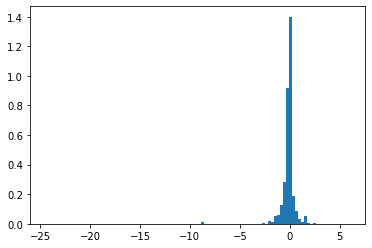

count    8918.00000000
mean       -0.14890057
std         0.90560291
min       -24.48859519
25%        -0.30292369
50%        -0.05322982
75%         0.04548383
max         6.02700450
Name: ret_1, dtype: float64

In [56]:
dfg = df.loc[df[ret_class] != 0]
dfg.shape[0]

fig, ax = plt.subplots()

ax.hist(dfg[ret_class].values, bins=100, density=True)
plt.show()

dfg[ret_class].describe()

# Conditional

## buy

(array([5.64904749e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.64904749e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.64904749e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.64904749e-04, 0.00000000e+00, 2.82452374e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

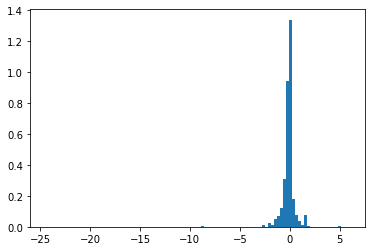

count    5801.00000000
mean       -0.12676929
std         0.78500245
min       -24.48859519
25%        -0.31419715
50%        -0.06008123
75%         0.04548383
max         6.02700450
Name: ret_1, dtype: float64

In [57]:
dfg = df.loc[(df['buy']>0) & (df[ret_class]!=0)]

buy = dfg['buy'].values
ret = dfg[ret_class].values

fig, ax = plt.subplots()

ax.hist(ret,bins=100, density=True)
plt.show()

df.loc[(df['buy'] >0) & (df[ret_class]!=0)][ret_class].describe()

## Sell

(array([2.31483688e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.15741844e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

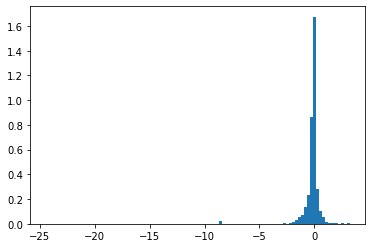

count    3117.00000000
mean       -0.19008875
std         1.09420276
min       -24.48859519
25%        -0.26363981
50%        -0.03710699
75%         0.04561274
max         3.23010116
Name: ret_1, dtype: float64

In [58]:
dfg = df.loc[(df['buy']<0) & (df[ret_class]!=0)]

buy = dfg['buy'].values
ret = dfg[ret_class].values

fig, ax = plt.subplots()

ax.hist(ret,bins=100, density=True)
plt.show()

df.loc[(df['buy'] <0) & (df[ret_class]!=0)][ret_class].describe()

In [65]:
df.loc[(df['buy']<0) & (df[ret_class]!=0)].sort_values('ret_1', ascending=True).head(1)

,id,amountUSD,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,insider_root,insider_tokenName,insider_tokenSymbol,insider_contractAddress,dex,chain,amount0Out,amount0In,amount1Out,amount1In,from,to,contract,buy,lp,insider_token_id,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3
1874,0x27af7005309858d413c73763d16973d5972ce4853396e71a8aa106408d029174-0,515.23197897,248,NaN,NaN,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,NaN,NaN,2021-08-02 12:45:55,Dogelon Moon,Wrapped Ether,0x708d6b8142897372e4f956252d1407192c22f2f7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x27af7005309858d413c73763d16973d5972ce4853396e71a8aa106408d029174,0xa19ed3aae7ea5fd905f80656cedb707b876846c0,Dogelon Moon,ELONMOON🚀,0x708d6B8142897372e4F956252d1407192c22F2F7,uniswapv2_ethereum,ethereum,0.0,1.75946127e+07,0.2,0.0,0xa19ed3aae7ea5fd905f80656cedb707b876846c0,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,False,-515.23197897,False,0x708d6b8142897372e4f956252d1407192c22f2f7,-24.48859519,0.0,0.0,0.0,0.0,0.0


# Total

In [67]:
print('Return One Day after the Insider Trading')
ret_class = 'ret_2'
print('\nUnconditional')
dfg = df.loc[df[ret_class] != 0]
dfg[ret_class].describe()

print('\nConditional on Buy')
dfg = df.loc[(df['buy']>0) & (df[ret_class]!=0)]
df.loc[(df['buy'] >0) & (df[ret_class]!=0)][ret_class].describe()

print('\nConditional on Sell')
dfg = df.loc[(df['buy']<0) & (df[ret_class]!=0)]
df.loc[(df['buy'] <0) & (df[ret_class]!=0)][ret_class].describe()

Return One Day after the Insider Trading

Unconditional


count    7796.00000000
mean       -0.22100024
std         0.91433928
min       -20.25636651
25%        -0.38150155
50%        -0.10164451
75%         0.06603951
max         5.28648061
Name: ret_2, dtype: float64


Conditional on Buy


count    5095.00000000
mean       -0.20926756
std         0.81466696
min        -9.52001876
25%        -0.43920568
50%        -0.11954456
75%         0.05841302
max         5.28648061
Name: ret_2, dtype: float64


Conditional on Sell


count    2701.00000000
mean       -0.24313205
std         1.07736398
min       -20.25636651
25%        -0.32433626
50%        -0.06954151
75%         0.08963911
max         3.09894156
Name: ret_2, dtype: float64

# Debug

In [66]:
after = True
day = 1

insider_token_id = '0x708d6b8142897372e4f956252d1407192c22f2f7'
timestamp = '2021-08-02 12:45:55'
dfr = pd.read_csv(f'{WD}dex_price/csv/{insider_token_id}.csv')

if after:
    start_row = dfr.loc[(pd.to_datetime(dfr['date']) > pd.to_datetime(timestamp) - datetime.timedelta(days=1))&
                          (pd.to_datetime(dfr['date']) < pd.to_datetime(timestamp))]

    end_row =  dfr.loc[(pd.to_datetime(dfr['date']) > pd.to_datetime(timestamp) + datetime.timedelta(days=day-1))&
                          (pd.to_datetime(dfr['date']) < pd.to_datetime(timestamp) + datetime.timedelta(days=day))]
else:
    start_row = dfr.loc[(pd.to_datetime(dfr['date']) > pd.to_datetime(timestamp) - datetime.timedelta(days=day+2))&
                          (pd.to_datetime(dfr['date']) < pd.to_datetime(timestamp) - datetime.timedelta(days=day+1))]

    end_row =  dfr.loc[(pd.to_datetime(dfr['date']) > pd.to_datetime(timestamp) - datetime.timedelta(days=2))&
                       (pd.to_datetime(dfr['date']) < pd.to_datetime(timestamp) - datetime.timedelta(days=1))]
if (start_row.shape[0] != 0)&(end_row.shape[0] != 0):
    start_price = start_row['priceUSD'].values[0]
    end_price = end_row['priceUSD'].values[0]
else:
    print('0')
    
if (start_price == 0)|(end_price == 0):
    print('0')
    
ret = np.log(end_price/start_price)
ret
start_row
end_row

-24.488595188405732

,id,dailyTxns,dailyVolumeETH,dailyVolumeToken,dailyVolumeUSD,date,priceUSD,totalLiquidityETH,totalLiquidityToken,totalLiquidityUSD,token_decimals,token_derivedETH,token_id,token_name,token_symbol,token_totalLiquidity,token_tradeVolume,token_totalSupply,token_tradeVolumeUSD,token_txCount,token_untrackedVolumeUSD
0,0x708d6b8142897372e4f956252d1407192c22f2f7-18841,38,4.92047180e+09,4.92047180e+09,111992.15242922,2021-08-02,0.00003886,77.14932581,5.19471743e+09,201867.4038863,18,0.0,0x708d6b8142897372e4f956252d1407192c22f2f7,Dogelon Moon,ELONMOON🚀,1.00000519e+15,1.00000492e+15,14448,539.29842944,39,201468.9912514


,id,dailyTxns,dailyVolumeETH,dailyVolumeToken,dailyVolumeUSD,date,priceUSD,totalLiquidityETH,totalLiquidityToken,totalLiquidityUSD,token_decimals,token_derivedETH,token_id,token_name,token_symbol,token_totalLiquidity,token_tradeVolume,token_totalSupply,token_tradeVolumeUSD,token_txCount,token_untrackedVolumeUSD
1,0x708d6b8142897372e4f956252d1407192c22f2f7-18842,1,1.00000000e+15,1.00000000e+15,0.99897433,2021-08-03,9.00000000e-16,0.00040197,1.00000519e+15,0.99897952,18,0.0,0x708d6b8142897372e4f956252d1407192c22f2f7,Dogelon Moon,ELONMOON🚀,1.00000519e+15,1.00000492e+15,14448,539.29842944,39,201468.9912514


## Price Chart

In [54]:
df = pd.read_csv(f'{RES}/insider_trading/token_related_txn/trading_and_return.csv')
df.sample(3)

,id,amountUSD,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,insider_root,insider_tokenName,insider_tokenSymbol,insider_contractAddress,dex,chain,amount0Out,amount0In,amount1Out,amount1In,from,to,contract,buy,lp,insider_token_id,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3
7962,0x5af78adb81000c72d08e812bb42469322bfdcef9053b19118ea9368080e525aa-0,258.57417786,198,NaN,NaN,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,NaN,NaN,2022-03-12 21:01:27,Wrapped Ether,Gumby Social Club,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe8ffa442e1787bdf6780cdd6cf1e8270eddf0283,0x5af78adb81000c72d08e812bb42469322bfdcef9053b19118ea9368080e525aa,0x1ddf5ba593a393405516caccec6f5ecaf5fafc0b,Gumby Social Club,GUMBY,0xe8fFa442e1787Bdf6780CDd6CF1e8270EDDf0283,uniswapv2_ethereum,ethereum,0.0,1.00000000e-01,4.69932289e+10,0.0,0x1ddf5ba593a393405516caccec6f5ecaf5fafc0b,0x1ddf5ba593a393405516caccec6f5ecaf5fafc0b,False,258.57417786,False,0xe8ffa442e1787bdf6780cdd6cf1e8270eddf0283,-0.01458041,-0.02999948,0.00000000,0.00000000,0.00000000,0.00000000
11347,0x0007e7777fe1ba7a7909ba3cc7f1d8987ddae01f2b9c26560621863034d0cac7-0,997.73970396,201,NaN,NaN,0x325e343f1de602396e256b67efd1f61c3a6b38bd,NaN,NaN,2021-09-15 19:57:29,Tether USD,ZigCoin,0x55d398326f99059ff775485246999027b3197955,0x8c907e0a72c3d55627e853f4ec6a96b0c8771145,0x0007e7777fe1ba7a7909ba3cc7f1d8987ddae01f2b9c26560621863034d0cac7,0xa68504aff087203bc987d575947c77b67cdae204,ZigCoin,ZIG,0x8C907e0a72C3d55627E853f4ec6a96b0C8771145,babyswap_binance,binance,0.0,9.97739704e+02,2.50000000e+04,0.0,0xa68504aff087203bc987d575947c77b67cdae204,0xa68504aff087203bc987d575947c77b67cdae204,False,997.73970396,False,0x8c907e0a72c3d55627e853f4ec6a96b0c8771145,-0.01524654,-0.02710035,-0.07236674,0.05494360,0.03172890,0.00966296
3889,0x846a12bdc7a5ebde62f01cf0199cc83ce4031d212d113c76672930541eeed720-0,107.59433439,18,NaN,NaN,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,NaN,NaN,2022-03-01 03:13:21,Kiba Inu,Wrapped Ether,0x4b2c54b80b77580dc02a0f6734d3bad733f50900,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x846a12bdc7a5ebde62f01cf0199cc83ce4031d212d113c76672930541eeed720,0x2c5b9dd42d0510c43f1d6d672bd56a7de0716c91,Kiba Inu,KIBA,0x005D1123878Fc55fbd56b54C73963b234a64af3c,uniswapv2_ethereum,ethereum,0.0,3.99508768e+07,3.69184396e-02,0.0,0x2c5b9dd42d0510c43f1d6d672bd56a7de0716c91,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,False,-107.59433439,False,0x4b2c54b80b77580dc02a0f6734d3bad733f50900,-0.31355277,0.09535617,0.50146073,0.02057358,-0.10654347,-0.06578245


,date,id,liquidity,liquidityAVAX,liquidityUSD,priceUSD,txCount,volume,volumeAVAX,volumeUSD,token_decimals,token_derivedAVAX,token_id,token_liquidity,token_name,token_symbol,token_totalSupply,token_txCount,token_untrackedVolumeUSD,token_volume,token_volumeUSD
0,2021-11-03,0x61ecd63e42c27415696e10864d70ecea4aa11289-18934,10239.49180777,30.03035518,2212.37510145,0.21606298,6,594.11504819,7.27305235,40.00473989,18,0.0011681,0x61ecd63e42c27415696e10864d70ecea4aa11289,39967.73407404,RUGPULL,RUGPULL,17040,2919,467237.53558427,1.43604477e+06,218317.57941045
1,2021-11-04,0x61ecd63e42c27415696e10864d70ecea4aa11289-18935,4800.51376786,14.07893441,1091.25902333,0.22732130,5,1014.70774264,0.00716793,227.83859844,18,0.0011681,0x61ecd63e42c27415696e10864d70ecea4aa11289,39967.73407404,RUGPULL,RUGPULL,17040,2919,467237.53558427,1.43604477e+06,218317.57941045
2,2021-11-05,0x61ecd63e42c27415696e10864d70ecea4aa11289-18936,4925.34335157,14.44503429,1069.05093356,0.21705105,3,355.68700523,0.00254789,79.92147784,18,0.0011681,0x61ecd63e42c27415696e10864d70ecea4aa11289,39967.73407404,RUGPULL,RUGPULL,17040,2919,467237.53558427,1.43604477e+06,218317.57941045
3,2021-11-06,0x61ecd63e42c27415696e10864d70ecea4aa11289-18937,4824.79278399,14.15013984,1100.00721308,0.22799056,3,356.44349405,0.00238834,79.57563212,18,0.0011681,0x61ecd63e42c27415696e10864d70ecea4aa11289,39967.73407404,RUGPULL,RUGPULL,17040,2919,467237.53558427,1.43604477e+06,218317.57941045
4,2021-11-07,0x61ecd63e42c27415696e10864d70ecea4aa11289-18938,7009.89366503,20.55859807,1766.49325293,0.25200001,4,197.48657850,0.00121858,48.83196822,18,0.0011681,0x61ecd63e42c27415696e10864d70ecea4aa11289,39967.73407404,RUGPULL,RUGPULL,17040,2919,467237.53558427,1.43604477e+06,218317.57941045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2022-08-02,0x61ecd63e42c27415696e10864d70ecea4aa11289-19206,40810.52950046,47.67089724,1104.19424663,0.02705660,1,828.99030644,0.00041744,22.42966063,18,0.0011681,0x61ecd63e42c27415696e10864d70ecea4aa11289,39967.73407404,RUGPULL,RUGPULL,17040,2919,467237.53558427,1.43604477e+06,218317.57941045
200,2022-08-06,0x61ecd63e42c27415696e10864d70ecea4aa11289-19210,41269.30933921,48.20679929,1280.90520821,0.03103772,4,507.55125450,0.00027322,15.51827365,18,0.0011681,0x61ecd63e42c27415696e10864d70ecea4aa11289,39967.73407404,RUGPULL,RUGPULL,17040,2919,467237.53558427,1.43604477e+06,218317.57941045
201,2022-08-10,0x61ecd63e42c27415696e10864d70ecea4aa11289-19214,42008.56926157,49.07033094,1458.34834552,0.03471550,1,739.25992236,0.00039599,25.66377536,18,0.0011681,0x61ecd63e42c27415696e10864d70ecea4aa11289,39967.73407404,RUGPULL,RUGPULL,17040,2919,467237.53558427,1.43604477e+06,218317.57941045
202,2022-08-15,0x61ecd63e42c27415696e10864d70ecea4aa11289-19219,41114.70969791,48.02621100,1389.72327167,0.03380112,1,893.85956367,0.00047880,30.21345514,18,0.0011681,0x61ecd63e42c27415696e10864d70ecea4aa11289,39967.73407404,RUGPULL,RUGPULL,17040,2919,467237.53558427,1.43604477e+06,218317.57941045


<AxesSubplot:xlabel='date'>

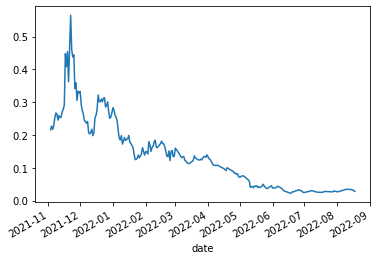

In [27]:
insider_token_id = '0x61ecd63e42c27415696e10864d70ecea4aa11289'
df = pd.read_csv(f'{WD}dex_price/csv/{insider_token_id}.csv')
df
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', ascending=True).set_index('date')['priceUSD'].astype('float').plot()

In [ ]:
df.loc[df['date'] == '', 'priceUSD']